In [1]:
import sys
sys.path.insert(0, '..')
from eda_import import *

from utils.cluster import cluster_clv_sites

In [2]:
print(datetime.datetime.today().date())

2018-05-11


In [3]:
TOTAL_NUM_CALLS = 67544140

In [5]:
%time adf = pd.read_pickle('../__results/all_cba.KLEAT.on-target-cleaned.filtered.pkl')

CPU times: user 574 ms, sys: 572 ms, total: 1.15 s
Wall time: 1.74 s


In [6]:
assert adf.shape[0] == 3420253

In [7]:
print('{0:.3%} data remained'.format(adf.shape[0] / TOTAL_NUM_CALLS))

5.064% data remained


# Add metadata

In [9]:
_cols = ['study', 'barcode', 'disease', 'disease_name', 'sample_type', 'sample_type_name', 
        'analyte_type', 'center', 'filename', 'files_size', 'checksum', 'analysis_id',
        'aliquot_id', 'participant_id', 'sample_id',  'tss_id', 'sample_accession',
        'published', 'uploaded', 'modified', 'sample_type_code',
        'analyte_type_code', 'platform_full_name']
df_manifest = pd.read_csv(
    '../metadata/LATEST_MANIFEST.final.tsv.gz', low_memory=False,
    usecols=_cols, sep='\t', compression='gzip')

In [10]:
%time bdf = adf.merge(df_manifest, on='analysis_id', how='left')

CPU times: user 1.46 s, sys: 637 ms, total: 2.1 s
Wall time: 2.09 s


In [11]:
assert bdf.shape[0] == adf.shape[0]

# Single-linkage Cluster

In [12]:
def cluster_to_stable(input_df):
    # This has the same effect with loop and then pd.concat, 
    # so function for apply returns a dataframe is fine

    # hierarchical clustering help reveal local structure, so clustering over all relevant data first.
    # In other words, cluster-then-filter instead of filter-then-cluster
    _df = input_df.copy()
    for i in range(2):
        print('{0} clustering...'.format(i))
        # cluster twice to final results more stable, see the experiment below
        # NOTE: %time magic inside function may mess up with the returned value
        _df = _df.groupby('gene_name').apply(cluster_clv_sites, 20).reset_index(drop=True)
    return _df

In [13]:
%time cdf = cluster_to_stable(bdf)

0 clustering...
1 clustering...
CPU times: user 29.8 s, sys: 4.46 s, total: 34.2 s
Wall time: 34.2 s


### Update aclv with regard to mclv

aclv (annotated median CSs) was initially calculated with CSs before filtering (clv), their distances were used for filtering. After clusterings, due to the following possibilities,

1. because 2 clv could corresponding to 2 aclv, but still be clustered together
1. median could take an average, check np.median([2, 4]) is 3, so better just redo mapping

so update alcv

In [14]:
df_clv_sc = pd.read_csv('../__results/annotated-clv-sc-mapping.csv')
# first create a dict of gene-to-clvs map
# ONLY use the mclv value in annotation, its clv is mainly for debugging purpose
ANNOT_GENE2CLV_DD = df_clv_sc.groupby(['gene_name']).apply(lambda g: g.aclv.unique())
def map_kclv2aclv(row):
    """map KLEAT predicted clv to a closest annotated clv"""
    gene = row.gene_name
    kclv = row['mclv']
    poss_aclvs = ANNOT_GENE2CLV_DD[gene]
    return poss_aclvs[np.argmin(np.abs(poss_aclvs - kclv))]

In [15]:
cdf2 = cdf.copy()

In [16]:
_df = cdf[['gene_name', 'mclv']].drop_duplicates()

In [17]:
_df['aclv'] = _df.apply(map_kclv2aclv, axis=1)

In [18]:
assert _df.shape == (2136, 3)

In [19]:
_df.head(2)

,gene_name,mclv,aclv
0,ABL1,133763062,133763062
14,ABL1,133589972,133763062


In [20]:
cdf2.drop('aclv', axis=1, inplace=True)

In [21]:
%time cdf2 = cdf2.merge(_df, on=['gene_name', 'mclv'], how='left')

CPU times: user 3.38 s, sys: 453 ms, total: 3.84 s
Wall time: 3.83 s


In [22]:
# only additional columns are added, the number of rows shouldn't change
assert cdf2.shape[0] == bdf.shape[0] 

# Compare dist(clv, mclv) and dist(clv, aclv)

In [23]:
# ax = cdf2.signed_NDA.plot.hist(bins=np.arange(-25, 25, 1), label='Dist. to annotated CS', normed=True, histtype='step')
# (cdf2['clv'] - cdf2['mclv']).plot.hist(bins=np.arange(-25, 25, 1), ax=ax, label='Dist. to rep. CS', normed=True, histtype='step')

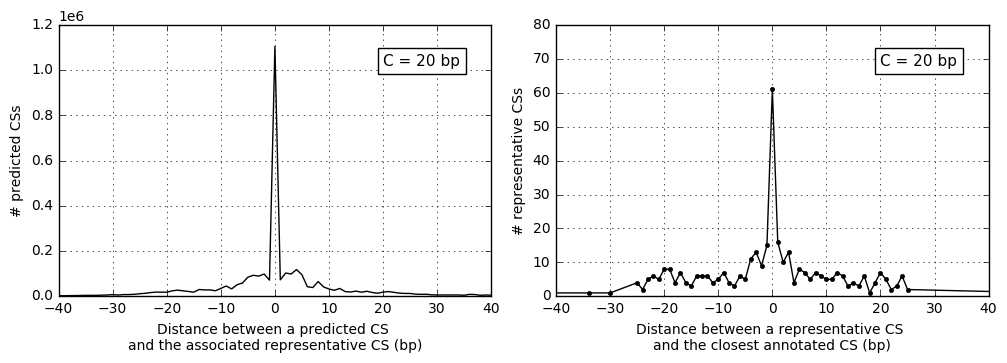

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), gridspec_kw={'wspace': 0.15})
axes = axes.ravel()

ax1 = axes[0]

# cdf2.signed_NDA.value_counts().sort_index().plot(ax1=ax1, lw=1, label='Dist. to annotated CS')
(cdf2['clv'] - cdf2['mclv']).value_counts().sort_index().plot(ax=ax1, color='k', lw=1)

ax1.legend().remove()
ax1.set_xlim(-40, 40)
ax1.set_xlabel('Distance between a predicted CS \nand the associated representative CS (bp)')
ax1.set_ylabel('# predicted CSs')
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.text(0.75, 0.85, 'C = 20 bp', transform=ax1.transAxes, fontsize=11, bbox=dict(facecolor='white'))
ax1.grid()

ax2 = axes[1]
_df = cdf2[['seqname', 'gene_name', 'strand', 'mclv', 'aclv']].drop_duplicates()
_df['sdist_mclv2aclv'] = _df['mclv'] - _df['aclv']
# _df['NDA'] = _df['sdist_mclv2aclv'].abs().values
_df['sdist_mclv2aclv'].value_counts().sort_index().plot(ax=ax2, lw=1, color='k', marker='o', markersize=3)
ax2.legend().remove()
ax2.set_xlim(-40, 40)
ax2.set_ylim(0, 80)
ax2.set_xlabel('Distance between a representative CS \nand the closest annotated CS (bp)')
ax2.set_ylabel('# representative CSs')
ax2.text(0.75, 0.85, 'C = 20 bp', transform=ax2.transAxes, fontsize=11, bbox=dict(facecolor='white'))
ax2.grid()

# plt.tight_layout()

In [25]:
uniq_clv_sites = cdf2.groupby(['gene_name', 'seqname', 'strand']).apply(lambda g: np.sort(g.mclv.unique())).reset_index(name='clv_sites')
uniq_clv_sites['neighbor_dist'] = uniq_clv_sites.clv_sites.apply(lambda v: np.diff(v))
uniq_clv_sites['max_neighbor_dist'] = uniq_clv_sites.neighbor_dist.apply(lambda v: max(v) if len(v) > 0 else 0)
uniq_clv_sites['min_neighbor_dist'] = uniq_clv_sites.neighbor_dist.apply(lambda v: min(v) if len(v) > 0 else 0)

In [26]:
# filter > 0 because some of clv sites list have only 1 element
uniq_clv_sites.query('min_neighbor_dist > 0').sort_values('min_neighbor_dist').head(2)

,gene_name,seqname,strand,clv_sites,neighbor_dist,max_neighbor_dist,min_neighbor_dist
6,ATM,chr11,+,"[108098580, 108099025, 108100091, 108106758, 108107768, 108110228, 108114962, 108121651, 108122015, 108124556, 108127108, 108137384, 108138304, 108138908, 108143692, 108153590, 108158310, 108159785, 108166714, 108167520, 108168108, 108168542, 108168723, 108172552, 108173763, 108173894, 108178439, 108179944, 108186638, 108188186, 108188207, 108189117, 108194673, 108196846, 108198597, 108202793, 108207135, 108207637, 108207845, 108209473, 108212292, 108213968, 108214136, 108214829, 108216800, 108216904, 108226866, 108226948, 108227321, 108235808, 108236933, 108237216, 108239440, 108239609, 108239827, 108240226, 108243826, 108250380, 108272055]","[445, 1066, 6667, 1010, 2460, 4734, 6689, 364, 2541, 2552, 10276, 920, 604, 4784, 9898, 4720, 1475, 6929, 806, 588, 434, 181, 3829, 1211, 131, 4545, 1505, 6694, 1548, 21, 910, 5556, 2173, 1751, 4196, 4342, 502, 208, 1628, 2819, 1676, 168, 693, 1971, 104, 9962, 82, 373, 8487, 1125, 283, 2224, 169, 218, 399, 3600, 6554, 21675]",21675,21
83,PTCH1,chr9,-,"[98180252, 98205278, 98205693, 98206117, 98206430, 98208439, 98208647, 98219609, 98219724, 98223833, 98223854, 98242763, 98242800, 98243963, 98244110, 98244231, 98248136, 98264897, 98266344, 98268689, 98268715, 98269924, 98272361, 98272770, 98273969, 98276946]","[25026, 415, 424, 313, 2009, 208, 10962, 115, 4109, 21, 18909, 37, 1163, 147, 121, 3905, 16761, 1447, 2345, 26, 1209, 2437, 409, 1199, 2977]",25026,21


In [27]:
uniq_clv_sites.query('max_neighbor_dist > 0').sort_values('max_neighbor_dist').iloc[::-1].head(2)

,gene_name,seqname,strand,clv_sites,neighbor_dist,max_neighbor_dist,min_neighbor_dist
14,CCND1,chr11,+,"[69456448, 69463021, 69463298, 69463478, 69469242, 69469769, 69882117]","[6573, 277, 180, 5764, 527, 412348]",412348,180
19,CDKN2A,chr9,-,"[21653556, 21967755, 21967992, 21968200, 21968733, 21969564, 21970697, 21973076, 21974215, 21980502, 21982173, 21986307, 21987209, 21987318, 21988068, 21988205, 21989339, 21993202, 21994884, 21995265]","[314199, 237, 208, 533, 831, 1133, 2379, 1139, 6287, 1671, 4134, 902, 109, 750, 137, 1134, 3863, 1682, 381]",314199,109


In [28]:
flat_dists = pd.Series(list(itertools.chain(*uniq_clv_sites.neighbor_dist.values)))
flat_dists.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
0,2022.0,4733.832839,14722.233129,21.0,308.5,1195.0,4664.5,412348.0


In [29]:
cdf2.columns

Index(['gene_name', 'strand', 'seqname', 'clv', 'length_of_tail_in_contig', 'number_of_bridge_reads', 'max_bridge_read_tail_length', 'analysis_id', 'clv0', 'hexamer', 'hexamer_id', 'hexamer_loc0', 'hexamer_loc', 'signed_NDA', 'NDA', 'study', 'barcode', 'disease', 'disease_name', 'sample_type',
       'sample_type_name', 'analyte_type', 'center', 'filename', 'files_size', 'checksum', 'aliquot_id', 'participant_id', 'sample_id', 'tss_id', 'sample_accession', 'published', 'uploaded', 'modified', 'sample_type_code', 'analyte_type_code', 'platform_full_name', 'cluster_idx', 'mclv', 'aclv'],
      dtype='object')

In [30]:
ddf = cdf2.drop([
        'length_of_tail_in_contig', 
        'number_of_bridge_reads', 
        'max_bridge_read_tail_length',
        
        'signed_NDA', 
        'NDA',
        'study',
      
        'analyte_type', 'files_size', 'checksum', 'aliquot_id', 
        'sample_accession', 'published', 'uploaded', 'modified', 
        'sample_type_code', 'analyte_type_code', 'platform_full_name',
    ], axis=1)

In [31]:
ddf.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3420253 entries, 0 to 3420252
Columns: 23 entries, gene_name to aclv
dtypes: int64(8), object(15)
memory usage: 626.3+ MB


In [32]:
ddf.head(1)

,gene_name,strand,seqname,clv,analysis_id,clv0,hexamer,hexamer_id,hexamer_loc0,hexamer_loc,barcode,disease,disease_name,sample_type,sample_type_name,center,filename,participant_id,sample_id,tss_id,cluster_idx,mclv,aclv
0,ABL1,+,chr9,133763062,1d811d54-caa1-41f3-bfc2-400eebdd97ef,133763061,AATAAA,1,133763038,133763039,TCGA-KN-8425-01A-11R-2315-07,KICH,KIDNEY CHROMOPHOBE,TP,Primary solid Tumor,UNC-LCCC,UNCID_2186137.d42c9589-3960-4964-be28-83d275bdc672.121106_UNC11-SN627_0258_AC11WRACXX_6_TGACCA.tar.gz,cc316faf-dcb1-4dea-b8b0-a17d000ff40f,84ed1792-cec8-4f98-9988-74b3f5f6f516,KN,1,133763062,133763062


In [33]:
assert ddf.shape[0] == adf.shape[0]

In [34]:
ddf['sstype'] = ddf.sample_type.apply(lambda x: 'normal' if x == 'NT' else 'tumour')

In [35]:
def add_kid(df):
    """kid: cleavage site id"""
    df['kid'] = (df.seqname.astype(str)
          + '|' + df.gene_name
          + '|' + df.strand
          + '|' + df.clv.astype(str))
    
def add_mkid(df):
    """mkid: mode cleavage site id"""
    df['mkid'] = (df.seqname.astype(str)
          + '|' + df.gene_name
          + '|' + df.strand
          + '|' + df.mclv.astype(str))
    
def add_akid(df):
    """akid: annotated mode cleavage site id"""
    df['akid'] = (df.seqname.astype(str)
          + '|' + df.gene_name
          + '|' + df.strand
          + '|' + df.aclv.astype(str))

In [36]:
%%time
add_kid(ddf)
add_mkid(ddf)
add_akid(ddf)

CPU times: user 20.4 s, sys: 2.61 s, total: 23 s
Wall time: 23 s


In [38]:
%%time
# Since this will be released for public, csv is more portable though much slower than pickle
ddf.to_csv('../__results/all_cba.KLEAT.on-target-cleaned.filtered.clustered.csv',
              index=False)

CPU times: user 55.1 s, sys: 1.41 s, total: 56.5 s
Wall time: 57.9 s


In [39]:
assert ddf.shape[0] == 3420253

In [40]:
ddf.head(2)

,gene_name,strand,seqname,clv,analysis_id,clv0,hexamer,hexamer_id,hexamer_loc0,hexamer_loc,barcode,disease,disease_name,sample_type,sample_type_name,center,filename,participant_id,sample_id,tss_id,cluster_idx,mclv,aclv,sstype,kid,mkid,akid
0,ABL1,+,chr9,133763062,1d811d54-caa1-41f3-bfc2-400eebdd97ef,133763061,AATAAA,1,133763038,133763039,TCGA-KN-8425-01A-11R-2315-07,KICH,KIDNEY CHROMOPHOBE,TP,Primary solid Tumor,UNC-LCCC,UNCID_2186137.d42c9589-3960-4964-be28-83d275bdc672.121106_UNC11-SN627_0258_AC11WRACXX_6_TGACCA.tar.gz,cc316faf-dcb1-4dea-b8b0-a17d000ff40f,84ed1792-cec8-4f98-9988-74b3f5f6f516,KN,1,133763062,133763062,tumour,chr9|ABL1|+|133763062,chr9|ABL1|+|133763062,chr9|ABL1|+|133763062
1,ABL1,+,chr9,133763062,3f5db931-1844-42e6-ab69-54f851b34693,133763061,AATAAA,1,133763038,133763039,TCGA-KN-8419-11A-01R-2315-07,KICH,KIDNEY CHROMOPHOBE,NT,Solid Tissue Normal,UNC-LCCC,UNCID_2186044.0d5727f8-2f06-4b7e-bc23-0241d44594cc.121106_UNC11-SN627_0258_AC11WRACXX_4_GTGAAA.tar.gz,dc04b82c-e1e8-4917-ba19-c2fea4a1b69a,04ab90cd-4030-46bc-8a3b-279b9dfaa24c,KN,1,133763062,133763062,normal,chr9|ABL1|+|133763062,chr9|ABL1|+|133763062,chr9|ABL1|+|133763062


In [41]:
assert ddf.mkid.unique().shape[0] == 2136

In [42]:
assert ddf[['seqname', 'gene_name', 'cluster_idx']].drop_duplicates().shape[0] == 2136

In [43]:
assert ddf.shape[0] == adf.shape[0]